In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import json
import os
import glob
import pandas as pd

%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
#kilosort path
kilosort_path=r"D:\tilda data\recording1\continuous\Neuropix-PXI-100.ProbeA-AP\kilosort4"
timestamps_path=r"D:\tilda data\recording1\continuous\Neuropix-PXI-100.ProbeA-AP\timestamps.npy"

#need to generate trials table with align_stimulus_times first
trials_path=r"D:\tilda data\recording1\MG019_Vis_2_20241024_152352_trials.csv"
plot_savepath=r"D:\tilda data\recording1\plots"

In [3]:
#load data
trials=pd.read_csv(trials_path)
spike_times=np.load(os.path.join(kilosort_path,"spike_times.npy"))
spike_clusters=np.load(os.path.join(kilosort_path,"spike_clusters.npy"))
cluster_group=pd.read_csv(os.path.join(kilosort_path,"cluster_group.tsv"),sep='\t')
probe_timestamps=np.load(os.path.join(timestamps_path))
spike_positions=np.load(os.path.join(kilosort_path,"spike_positions.npy"))
spike_templates=np.load(os.path.join(kilosort_path,"spike_templates.npy"))
templates=np.load(os.path.join(kilosort_path,"templates.npy"))

#find channel index of max template amplitude
template_max_channel=np.argmax(np.max(np.abs(templates),axis=1),axis=1)

In [4]:
spike_templates

array([285, 379,  30, ..., 307, 304, 132])

In [5]:
#all-spike histogram

real_spike_times=probe_timestamps[spike_times]

#bin spikes by stim_start_time
binsize=0.025
pre_stimulus_time=0.5
post_stimulus_time=1.5
tbins=np.arange(-pre_stimulus_time,post_stimulus_time,binsize)

stimuli=trials['stim_name'].unique()
stim_durations=trials.query('stim_duration!=0')['stim_duration'].unique()

stim_rasters_all_spikes={
    'vis1':{x:[] for x in stim_durations},
    'vis2':{x:[] for x in stim_durations},
    'sound1':{x:[] for x in stim_durations},
    'sound2':{x:[] for x in stim_durations},
    'catch':{x:[] for x in stim_durations},
}

for ss in stimuli:
    for dd in stim_durations:
        if ss=='catch':
            stim_trials=trials.query('stim_name==@ss')
        else:
            stim_trials=trials.query('stim_name==@ss and stim_duration==@dd')

        if len(stim_trials)==0:
            continue

        for tt in range(len(stim_trials)):
            trial=stim_trials.iloc[tt]
            window_start=trial['stim_start_time']-pre_stimulus_time
            window_end=trial['stim_start_time']+post_stimulus_time

            trial_spikes_ind=(real_spike_times>=window_start)&(real_spike_times<window_end)
            trial_spikes=real_spike_times[trial_spikes_ind]-trial['stim_start_time']
            hist,edges=np.histogram(trial_spikes,bins=tbins)
            stim_rasters_all_spikes[ss][dd].append(hist)
        
        stim_rasters_all_spikes[ss][dd]=np.vstack(stim_rasters_all_spikes[ss][dd])


Text(0.5, 0.98, 'stim: vis1')

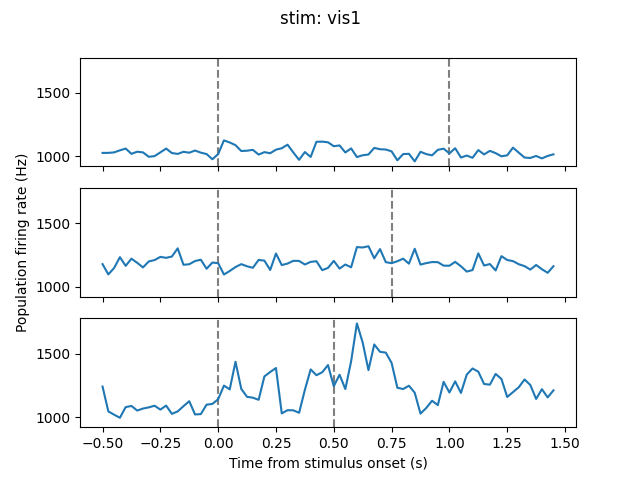

In [6]:
# change sel_stim to one of ['vis1','vis2','sound1','sound2','catch'] to plot stimulus specific rasters
sel_stim='vis1'

fig,ax=plt.subplots(3,1,sharey=True,sharex=True)
for xx,dd in enumerate(stim_durations):
    ax[xx].axvline(0,linestyle='--',color='k',alpha=0.5)
    ax[xx].axvline(dd,linestyle='--',color='k',alpha=0.5)
    ax[xx].plot(tbins[:-1],np.nanmean(stim_rasters_all_spikes[sel_stim][dd],0)/binsize,label=str(dd)+'s')
    
ax[1].set_ylabel('Population firing rate (Hz)')
ax[-1].set_xlabel('Time from stimulus onset (s)')

fig.suptitle('stim: '+sel_stim)


In [7]:
#make simple unit table
#this makes it way easier to work with the data
units={'unit_id':[], #the unit ID assigned from kilosort - NOT UNIQUE ACROSS PROBES!
       'quality':[], #good or mua - reflects estiamte of unit quality from kilosort based on refractory period violations
       'firing_rate':[], #average firing rate of the unit across entire recording
       'channel':[], #which channel had the largest signal from this unit
       'spike_times':[], #spike times of the unit
       'template':[], #template of the unit - approximately the average waveform of the unit
       'template_index':[] #index of the template in the templates array
       }

for uu,unit in cluster_group.iterrows():
    unit_id=unit['cluster_id']
    unit_spike_times=probe_timestamps[spike_times[spike_clusters==unit_id]]
    unit_template_index,_=stats.mode(spike_templates[spike_clusters==unit_id])
    unit_channel=template_max_channel[unit_template_index]
    unit_template=templates[unit_template_index]
    units['unit_id'].append(unit_id)
    units['quality'].append(unit['KSLabel'])
    units['firing_rate'].append(len(unit_spike_times)/(probe_timestamps[-1]-probe_timestamps[0]))
    units['channel'].append(unit_channel)
    units['spike_times'].append(unit_spike_times)
    units['template'].append(unit_template)
    units['template_index'].append(unit_template_index)

units=pd.DataFrame(units)
units


,unit_id,quality,firing_rate,channel,spike_times,template,template_index
0,0,mua,7.210696,0,"[297.3877302117296, 354.4608296720403, 354.794...","[[0.08453215, 0.06394699, 0.08442618, 0.055523...",0
1,1,mua,2.350895,2,"[495.82508110004085, 756.7278988560053, 797.77...","[[0.21307267, 0.5048532, -1.0370182, 0.4669847...",1
2,2,mua,3.268762,2,"[170.94498950946004, 348.77023568420384, 348.7...","[[0.40094748, 0.3052727, 0.5087325, 0.37737405...",2
3,3,mua,3.634503,2,"[351.07156242519204, 800.9294258811675, 804.22...","[[-0.2146629, -0.20301044, 0.5350783, -0.25889...",3
4,4,mua,8.245444,2,"[281.7365460174838, 563.8575895588344, 563.874...","[[0.100725815, 0.080769226, -0.19666353, 0.106...",4
...,...,...,...,...,...,...,...
394,394,good,2.364432,374,"[42.42639139502887, 42.58055708188226, 42.9009...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",394
395,395,good,0.702587,376,"[43.2384580949618, 45.66669218742105, 45.87212...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",395
396,396,mua,0.277755,378,"[2381.280268388575, 2381.2856017069794, 2381.4...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",396
397,397,mua,0.849144,382,"[68.6209515000647, 68.62261816228272, 2381.222...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",397


In [8]:
#save units table
units.to_csv(os.path.join(kilosort_path,'units.csv'),index=False)

In [9]:
# select a unit to plot, currently only looking at "good" units
sel_unit_index=27

sel_unit=units.query('quality=="good"').iloc[sel_unit_index]
unit_spike_times=sel_unit['spike_times']

sel_unit

unit_id                                                         133
quality                                                        good
firing_rate                                                2.435237
channel                                                         132
spike_times       [42.21952542869336, 42.28959185815243, 42.2985...
template          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
template_index                                                  133
Name: 133, dtype: object

In [10]:
#bin spikes by stim_start_time

binsize=0.025
pre_stimulus_time=0.5
post_stimulus_time=1.5
tbins=np.arange(-pre_stimulus_time,post_stimulus_time,binsize)

stimuli=trials['stim_name'].unique()
stim_durations=trials.query('stim_duration!=0')['stim_duration'].unique()

stim_rasters={
    'vis1':{x:[] for x in stim_durations},
    'vis2':{x:[] for x in stim_durations},
    'sound1':{x:[] for x in stim_durations},
    'sound2':{x:[] for x in stim_durations},
    'catch':{x:[] for x in stim_durations},
}

for ss in stimuli:
    for dd in stim_durations:
        if ss=='catch':
            stim_trials=trials.query('stim_name==@ss')
        else:
            stim_trials=trials.query('stim_name==@ss and stim_duration==@dd')

        if len(stim_trials)==0:
            continue

        for tt in range(len(stim_trials)):
            trial=stim_trials.iloc[tt]
            window_start=trial['stim_start_time']-pre_stimulus_time
            window_end=trial['stim_start_time']+post_stimulus_time

            trial_spikes_ind=(unit_spike_times>=window_start)&(unit_spike_times<window_end)
            trial_spikes=unit_spike_times[trial_spikes_ind]-trial['stim_start_time']
            hist,edges=np.histogram(trial_spikes,bins=tbins)
            stim_rasters[ss][dd].append(hist)
        
        stim_rasters[ss][dd]=np.vstack(stim_rasters[ss][dd])


Text(0.5, 0.98, 'unit 133; channel 132; stim: vis1')

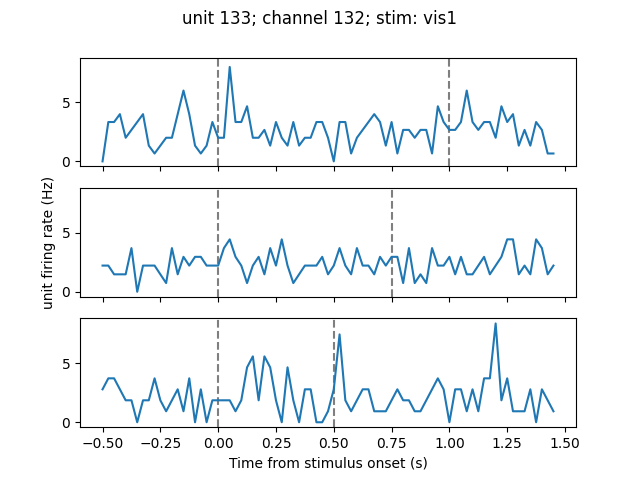

In [11]:
sel_stim='vis1'
fig,ax=plt.subplots(3,1,sharey=True,sharex=True)
for xx,dd in enumerate(stim_durations):
    ax[xx].axvline(0,linestyle='--',color='k',alpha=0.5)
    ax[xx].axvline(dd,linestyle='--',color='k',alpha=0.5)
    ax[xx].plot(tbins[:-1],np.nanmean(stim_rasters[sel_stim][dd],0)/binsize,label=str(dd)+'s')
    
ax[1].set_ylabel('unit firing rate (Hz)')
ax[-1].set_xlabel('Time from stimulus onset (s)')

fig.suptitle('unit '+str(sel_unit['unit_id'])+'; channel '+str(sel_unit['channel'])+'; stim: '+sel_stim)
